# Modello esponenziale

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import odeint
import pandas as pd
import emcee
import corner
from math import factorial as fact


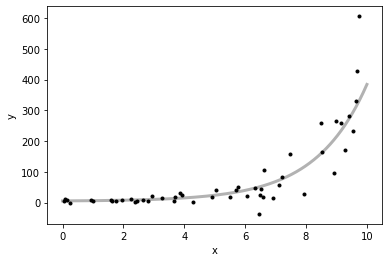

In [266]:
# Choose the "true" parameters.
m_true = 0.594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = np.exp(m_true * x) + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0,np.exp( m_true * x0) + b_true, "k", alpha=0.3, lw=3)
plt.xlabel("x")
plt.ylabel("y");

In [267]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = np.exp(m * x) + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 0.588
b = 4.593
f = 0.593


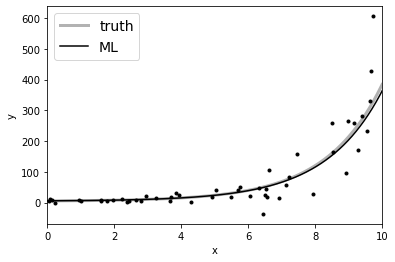

In [268]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.exp(m_true * x0) + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.exp(m_ml * x0) + b_ml, "k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [269]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 5.0 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [270]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1122.42it/s]


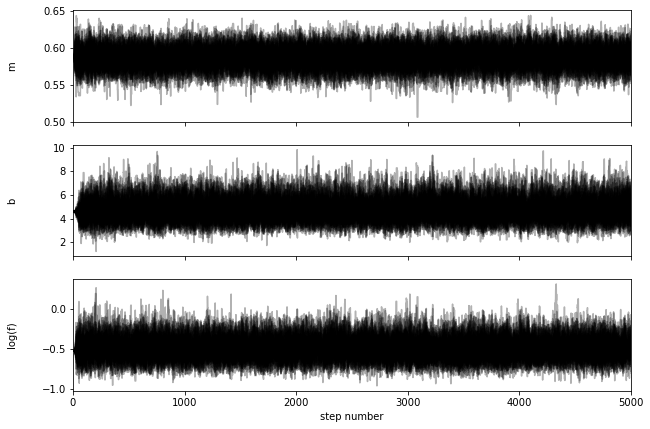

In [271]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [272]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 3)


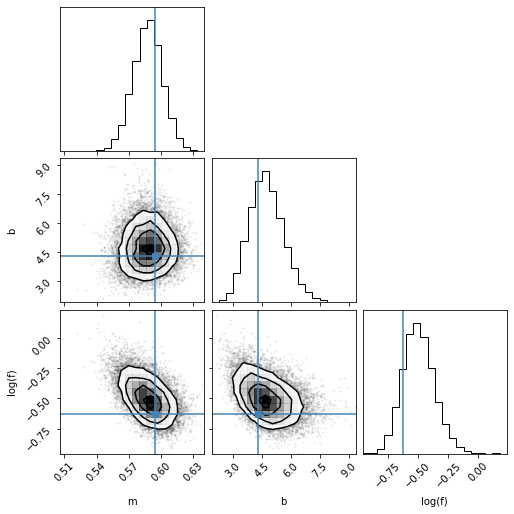

In [273]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

In [278]:
from IPython.display import display, Math

param_emcee=np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    param_emcee[i]=mcmc[1]
    display(Math(txt))
    


    
print("m = {0:.3f}".format(m_true))
print("b = {0:.3f}".format(b_true))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

m = 0.594
b = 4.294


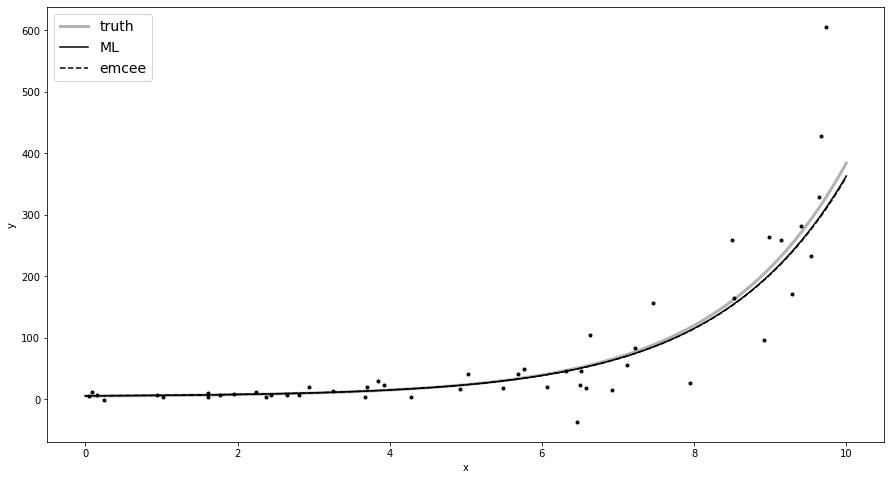

In [280]:
fig,ax=plt.subplots(figsize=(15,8))
ax.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
ax.plot(x0, np.exp(m_true * x0) + b_true, "k", alpha=0.3, lw=3, label="truth")
ax.plot(x0, np.exp(m_ml * x0) + b_ml, "k", label="ML")
ax.plot(x0, np.exp(param_emcee[0] * x0) + param_emcee[1], "--k", label="emcee")

ax.legend(fontsize=14)

ax.set_xlabel("x")
ax.set_ylabel("y");


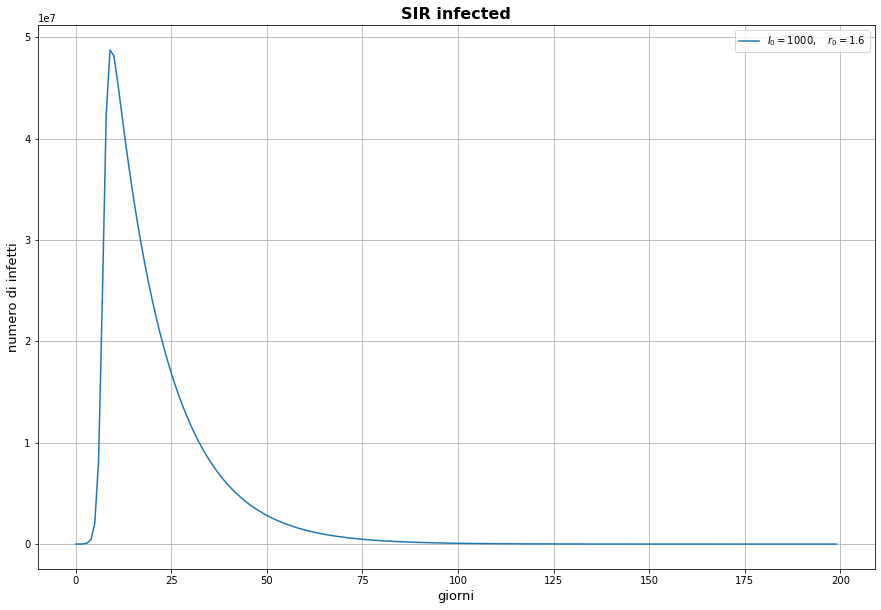

In [64]:

Popolazione=60e6
NORM=3e5
N=Popolazione


def SIR(y,t,gamma, beta):  #defining SIR equation
    S,I,R=y 
    dS_dt=-beta/N*S*I
    dI_dt=beta/N*S*I-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

def I_SIR(par, time):     #solving SIR equatuion
    I0,gamma,beta=par
    y0=[N-I0,I0,0]
    sol = odeint(SIR, y0, time, args=(gamma, beta))
    S,I,R=sol.T 
    return np.abs(I)

r_0_dangerous=1.6

# Choose the "true" parameters.
gamma=1./14
beta_dangerous=r_0_dangerous*gamma
I_0=1000

par=[I_0, gamma, beta_dangerous]
time=np.arange(0,200, 1)
infected=I_SIR([I_0, gamma, beta_dangerous], time)

fig, ax=plt.subplots(1,1, figsize=(15,10))
ax.plot(time, infected, linestyle='-', label=f'$I_0={I_0}, \quad r_0={r_0_dangerous}$')
ax.set_ylabel('numero di infetti', fontsize=13)
ax.set_xlabel('giorni', fontsize=13)
ax.set_title('SIR infected', fontsize=16, fontweight='bold')
ax.grid(True)
ax.legend(frameon=True, facecolor='w')
plt.show()

True parameters:
I_0 = 1000.000
gamma = 0.071
beta = 0.114
R_0 = 1.600


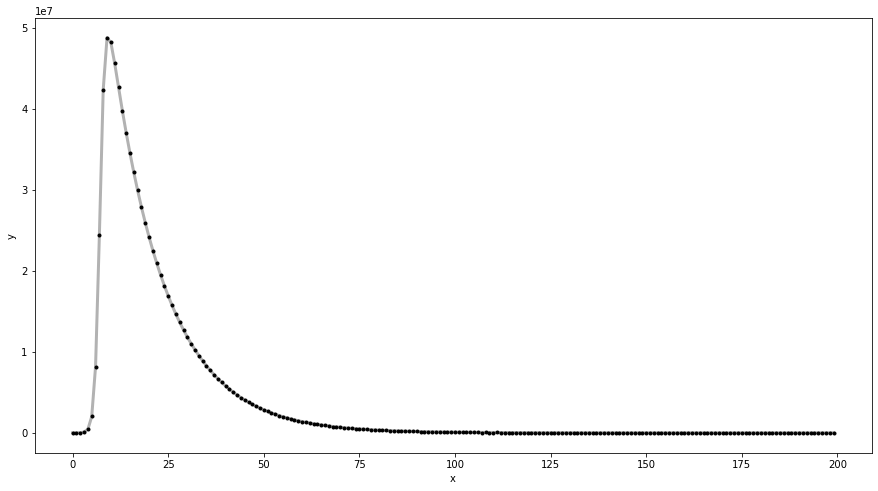

In [65]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)


# Generate some synthetic data from the model.

err = np.random.normal(0, np.sqrt(Popolazione), len(infected))
infected_with_error = err +infected
yerr = np.random.normal(0, np.sqrt(Popolazione), len(infected))

fig,ax=plt.subplots(figsize=(15,8))
ax.errorbar(time, infected_with_error, yerr=yerr, fmt=".k", capsize=0)
ax.plot(time,infected, "k", alpha=0.3, lw=3)
ax.set_xlabel("x")
ax.set_ylabel("y");

print("True parameters:")
print("I_0 = {0:.3f}".format(I_0))
print("gamma = {0:.3f}".format(gamma))
print("beta = {0:.3f}".format(beta_dangerous))
print("R_0 = {0:.3f}".format(beta_dangerous/gamma))



In [66]:
'''
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
'''


def log_likelihood2(par, time, infected):    #par(S0,beta, gamma)
  
    return np.sum( -(infected-I_SIR(par,time))**2/(2*I_SIR(par,time))-0.5*np.log(2*np.pi*I_SIR(par,time)) )


Maximum likelihood estimates:
I_0 = 1000.050
gamma = 0.076
beta = 0.028
R_0 = 0.368


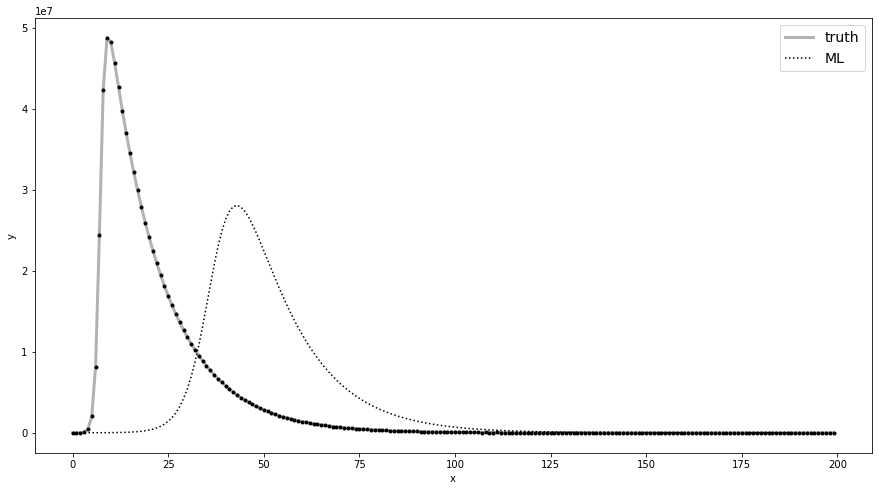

In [67]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood2(*args)
initial = np.array(par) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(time, infected_with_error))
I_0_ml, gamma_ml, betaz_ml = soln.x

print("Maximum likelihood estimates:")
print("I_0 = {0:.3f}".format(I_0_ml))
print("gamma = {0:.3f}".format(gamma_ml))
print("beta = {0:.3f}".format(beta_ml))
print("R_0 = {0:.3f}".format(beta_ml/gamma_ml))


fig,ax=plt.subplots(figsize=(15,8))
ax.errorbar(time, infected_with_error, yerr=yerr, fmt=".k", capsize=0)
ax.plot(time,infected, "k", alpha=0.3, lw=3, label="truth")
ax.plot(time, I_SIR([I_0_ml, gamma_ml, beta_ml], time), ":k", label="ML")
ax.legend(fontsize=14)

ax.set_xlabel("x")
ax.set_ylabel("y");

In [68]:
def log_prior(par):
    I0,gamma,beta=par
    
    I0_min,I0_max=0,100000
    gamma_min,gamma_max=0,2
    beta_min,beta_max=0,5
    
    if I0<I0_min or I0>I0_max or gamma<gamma_min or gamma>gamma_max or beta<beta_min or beta>beta_max:

        return -np.inf 
    else:
        return np.log( 1./(I0_max-I0_min) * 1./(gamma_max-gamma_min) * 1./(beta_max-beta_min))

def log_posterior(par, time, infected):
    if np.isfinite(log_prior(par)):
        return  log_liklihood(par,time,infected)+log_prior(par)
    else:
        return -np.inf

In [69]:
pos = soln.x + 1e-4 * np.random.randn(20, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(time, infected_with_error)
)
sampler.run_mcmc(pos, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [01:40<00:00,  9.92it/s]


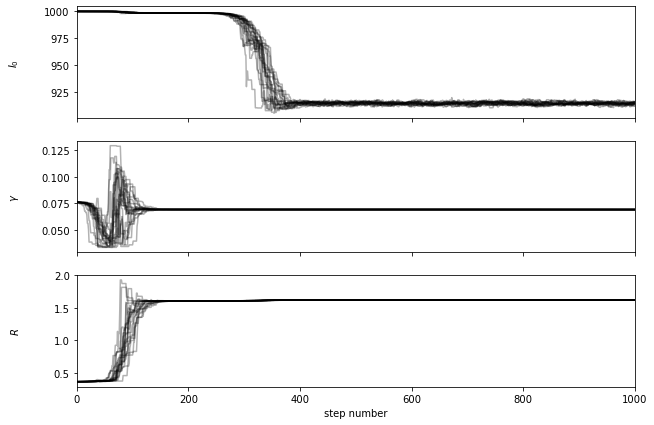

In [70]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$I_0$", r"$\gamma$", r"$R$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [71]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(660, 3)


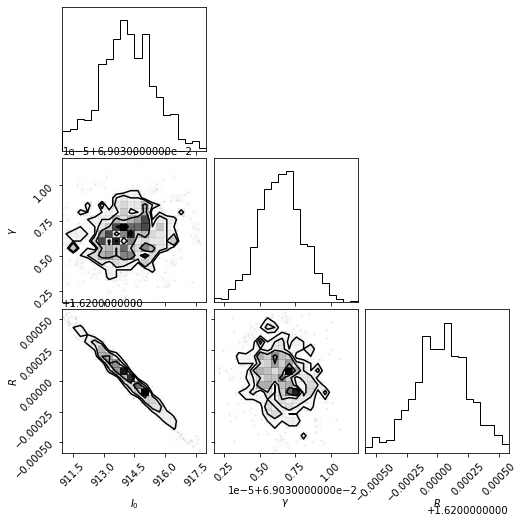

In [72]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[I_0, gamma, beta_dangerous]
);

In [73]:
from IPython.display import display, Math

param_emcee=np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    param_emcee[i]=mcmc[1]
    display(Math(txt))
    
txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(param_emcee[2]/param_emcee[1], q[0], q[1], 'R_0')
display(Math(txt))

    
print("True parameters:")
print("I_0 = {0:.3f}".format(I_0))
print("gamma = {0:.3f}".format(gamma))
print("beta = {0:.3f}".format(beta_dangerous))
print("R_0 = {0:.3f}".format(beta_dangerous/gamma))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

True parameters:
I_0 = 1000.000
gamma = 0.071
beta = 0.114
R_0 = 1.600


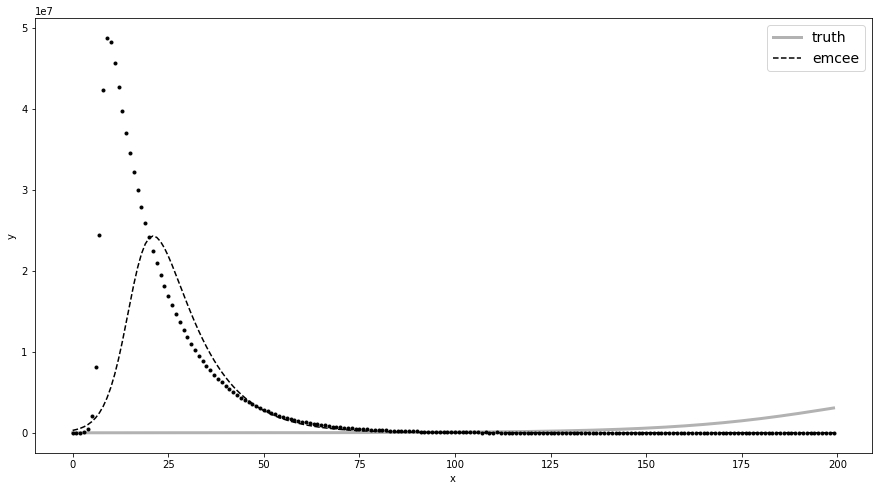

In [63]:
fig,ax=plt.subplots(figsize=(15,8))
ax.errorbar(time, infected_with_error, yerr=yerr, fmt=".k", capsize=0)
ax.plot(time,infected, "k", alpha=0.3, lw=3, label="truth")
#ax.plot(time, I_SIR([I_0_ml, gamma_ml, beta_ml], time), ":k", label="ML")
ax.plot(time, I_SIR(param_emcee, time), "--k", label="emcee")

ax.legend(fontsize=14)

ax.set_xlabel("x")
ax.set_ylabel("y");

Se gli errori e la varianza dei dati da analizzare non sono troppo alti entrambi i metodi danno ottimi risultati